<h1> MBA Upload and Download Speed Metric Charts Single TCP Connection </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

<h7>3/20/22</h7>

In [1]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [22]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> Bigquery SQL Queries

<h4> Download SQL Queries

In [7]:
peak_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        --PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpget` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpget` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""


fullDay_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        -- PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpget` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpget` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))

    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""

# Creating main dataframes
sPeak_download = client.query(peak_download_sql).to_dataframe()
sFullDay_download = client.query(fullDay_download_sql).to_dataframe()
print("Executed")



Executed


,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes,download_service_tier_1,ISP_1,tech_1,_80_80_
0,1.5,CenturyLink,DSL,1.181927,1.335136,0.303200,1.470792,0.961968,1.549048,0.005584,0.359374,29,1.5,CenturyLink,DSL,0.629032
1,4.0,Windstream,DSL,3.972575,4.366344,1.851344,4.400984,3.777024,4.632264,0.006904,0.861271,16,4.0,Windstream,DSL,2.357472
2,10.0,CenturyLink,DSL,9.039894,9.642176,5.503744,10.276784,7.932816,12.058632,0.351800,1.744637,29,10.0,CenturyLink,DSL,7.601944
3,12.0,CenturyLink,DSL,12.257977,12.840944,3.506064,16.499000,10.016456,16.900040,0.067040,3.717342,31,12.0,CenturyLink,DSL,7.723339
4,12.0,Windstream,DSL,12.496014,13.363672,6.320472,14.787272,12.067800,16.530248,0.436176,2.535263,18,12.0,Windstream,DSL,11.833136
5,15.0,Windstream,DSL,15.028461,16.276496,8.154928,16.538016,14.415208,16.621848,0.041432,2.901262,33,15.0,Windstream,DSL,12.881632
6,20.0,CenturyLink,DSL,18.902387,19.650832,10.073408,24.495384,16.091160,25.218248,0.015640,4.245212,21,20.0,CenturyLink,DSL,14.697523
7,25.0,CenturyLink,DSL,22.660414,23.938928,13.185264,26.236144,21.145168,27.694256,0.073744,4.168607,65,25.0,CenturyLink,DSL,17.857981
8,25.0,Comcast,Cable,28.121056,29.729056,19.825728,29.786456,28.644960,29.892208,0.998856,4.947077,10,25.0,Comcast,Cable,27.809731
9,75.0,Frontier,Fiber,80.415672,82.166472,73.166488,82.843672,80.795592,83.766040,15.825320,5.967740,13,75.0,Frontier,Fiber,77.949664


<h4> Upload SQL Queries

In [24]:
peak_upload_sql = """

SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httppost` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
        ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (SELECT
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httppost` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech

"""

fullDay_upload_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httppost` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (SELECT
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httppost` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech


"""

sPeak_upload = client.query(peak_upload_sql).to_dataframe()
sFullDay_upload = client.query(fullDay_upload_sql).to_dataframe()
print("Executed")

Executed


<hr>

<H5> Python functions

In [10]:
def dfNormalizerD(df):
    
    ispTech =  df['download_service_tier'].astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']
    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty ))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

def dfNormalizerU(df):
    
    ispTech =  df['upload_service_tier'].astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']   
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['upload_service_tier'] 
    isp = df['ISP']
        
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result
    

In [15]:
sPeakDChart = dfNormalizerD(sPeak_download) 
sOffPeakDChart = dfNormalizerD(sFullDay_download) 
sPeakUChart = dfNormalizerU(sPeak_upload) 
sOffPeakUChart = dfNormalizerU(sFullDay_upload) 


<h3> Single TCP Download Speed Connection Charts

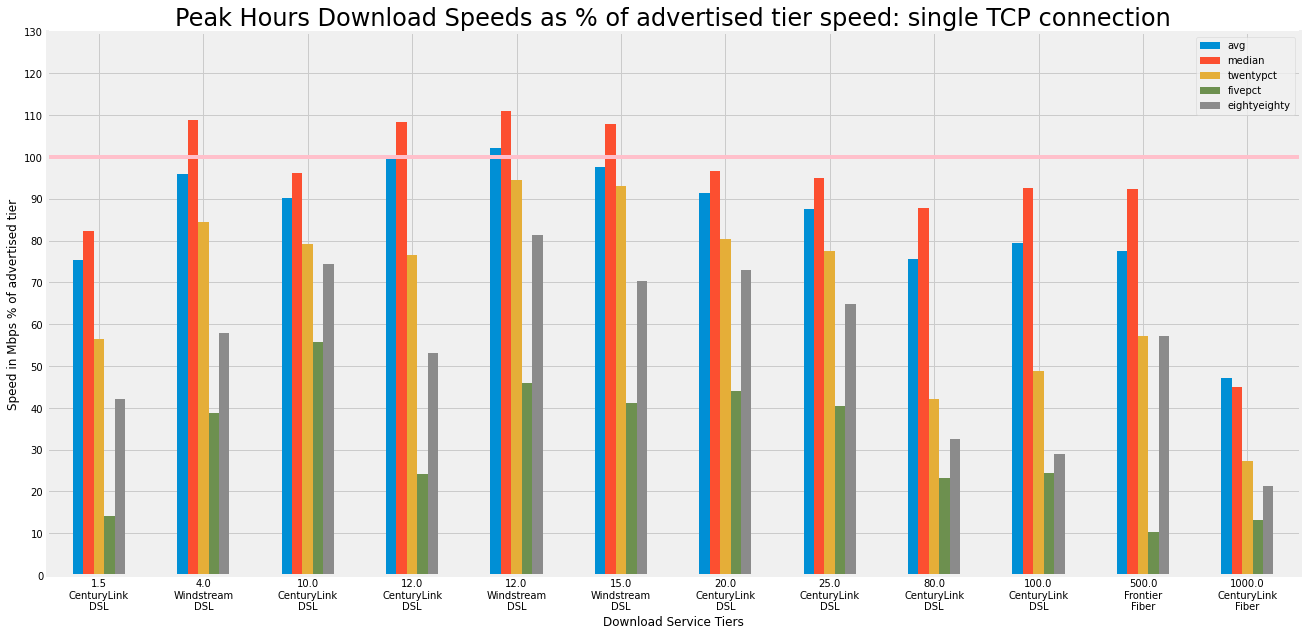

In [16]:
chartData = sPeakDChart

ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Peak Hours Download Speeds as % of advertised tier speed: single TCP connection', fontsize=24)


plt.show()

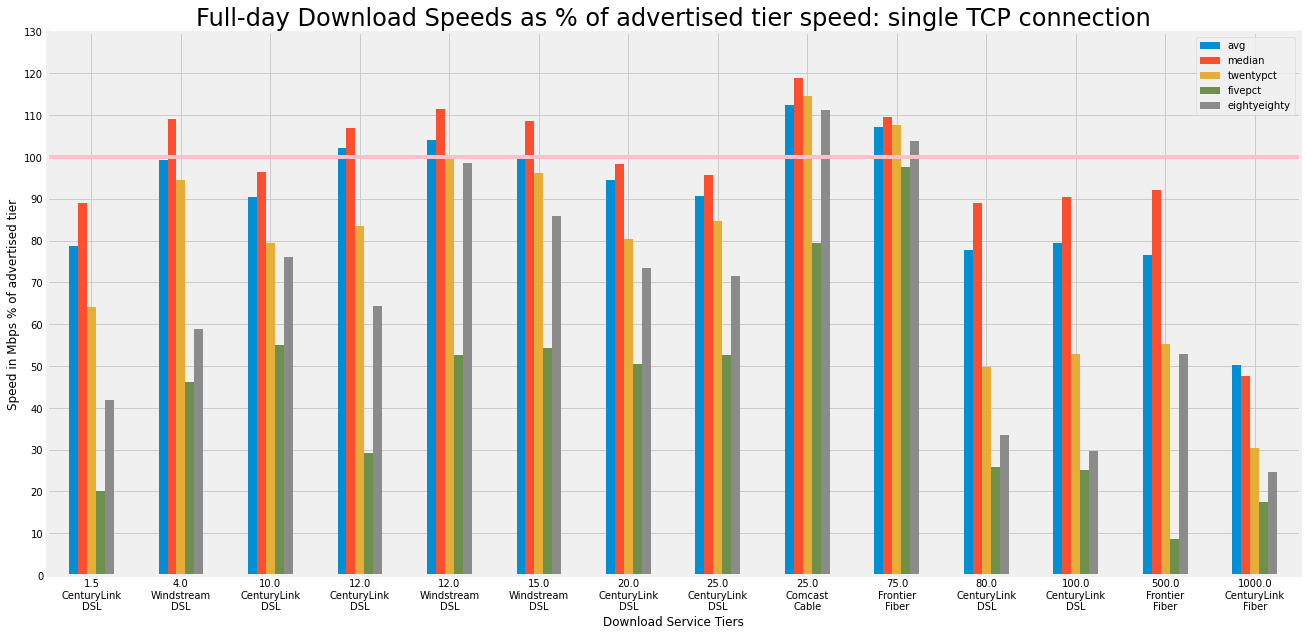

In [17]:
chartData = sOffPeakDChart

ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Full-day Download Speeds as % of advertised tier speed: single TCP connection', fontsize=24)


plt.show()

<hr>

<h3> Single TCP Upload Speed Connection Charts

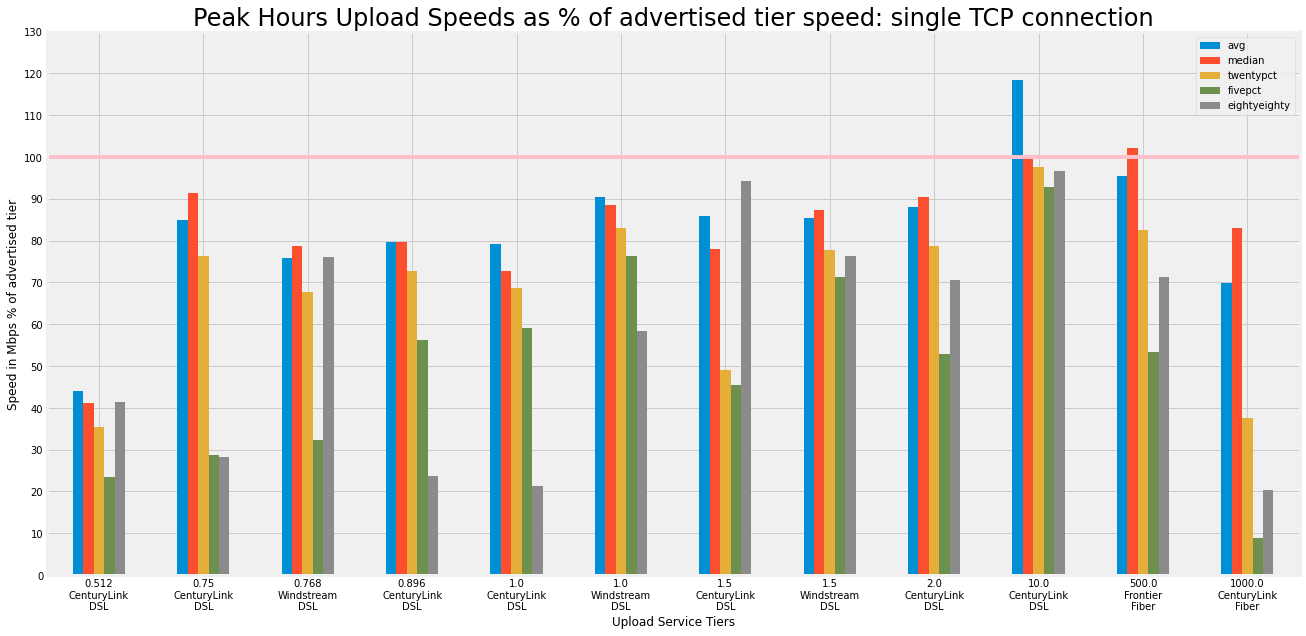

In [18]:
chartData = sPeakUChart



ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Peak Hours Upload Speeds as % of advertised tier speed: single TCP connection', fontsize=24)


plt.show()

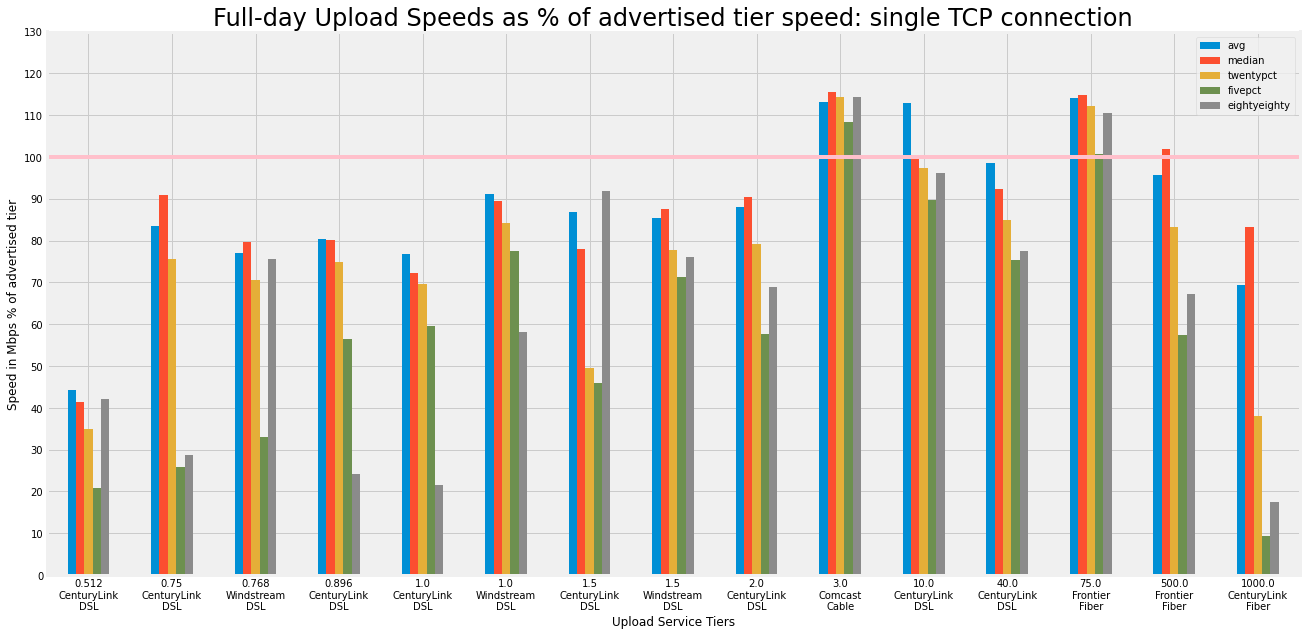

In [21]:
chartData = sOffPeakUChart



ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Full-day Upload Speeds as % of advertised tier speed: single TCP connection', fontsize=24)


plt.show()